In [ ]:
x# data source https://www.kaggle.com/datasets/ankkur13/edmundsconsumer-car-ratings-and-reviews

In [ ]:
# don't forget to connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import os 
import glob
from time import time
from nltk.stem import PorterStemmer, WordNetLemmatizer
#import nlp tools
import nltk, string,re
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.stem import PorterStemmer, WordNetLemmatizer
import gensim
import pickle
from pathlib import Path
import shutil

# Building the Car Review Dataframe

In [ ]:
HOME_DIR = Path("drive/MyDrive/Recys-Project/New-data")
archive_path = Path("drive/MyDrive/archive.zip")

In [ ]:
def get_df(HOME_DIR, archive_path):
  """
  This function unzip the folder and returns a pandas dataframe
  Argument(s)
  -------------
  HOME_DIR : Path to save files
  archive_path : path to zipped file
  
  Return(s)
  -------------
  df : pandas DataFrame of all the files il the zipped folder
  """
  # create a HOME_DIR if it doesn't exist  
  if not HOME_DIR.exists():
    os.mkdir(HOME_DIR)
  # Unzip file saved in archive path and save to HOME_DIR
  shutil.unpack_archive(archive_path, HOME_DIR)
  # get a list of the full address of all files in HOME_DIR
  all_files = [HOME_DIR / x for x in os.listdir(HOME_DIR)]
  all_df = (pd.read_csv(f,lineterminator='\n',index_col=0) for f in all_files)
  df  = pd.concat(all_df, ignore_index=True)
  return df


In [ ]:
df = get_df(HOME_DIR, archive_path)

In [ ]:
df.head()

Review_Date   Author_Name  \
0   on 10/13/05 15:30 PM (PDT)     roadking    
1   on 07/17/05 21:59 PM (PDT)         Mark    
2   on 07/16/02 00:00 AM (PDT)    Tom Sheer    
3   on 12/29/07 21:57 PM (PST)  Keven Smith    
4   on 02/09/05 18:52 PM (PST)       VanMan    

                                       Vehicle_Title  \
0  2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...   
1  2002 Dodge Ram Cargo Van 3500 3dr Ext Van (5.2...   
2  2002 Dodge Ram Cargo Van 3500 Maxi 3dr Ext Van...   
3  2001 Dodge Ram Cargo Van 2500 Maxi 3dr Ext Van...   
4  2001 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...   

                Review_Title  \
0     Great delivery vehicle   
1             Disappointmnet   
2                  Sweet van   
3                Keven Smith   
4  Not what Dodge used to be   

                                              Review  Rating\r  
0   It's been a great delivery vehicle for my caf...     4.625  
1   Bought this car as a commuter vehicle for a v...     2.125  
2   This van rocks its the best, lots of \rroom. ...     5.000  
3   Great work vehicle. Drives nice. has lots of ...     4.500  
4   Good solid frame and suspension.  Well equipp...     2.875

In [ ]:
def get_car_year(df, car_year, review_date, year):
  """
  This function retrieves the car year from the column specified as car year and
  return only cars after the specified date and convert review time to datetime
  Argument(s)
  -------------
  df: pandas dataframe
  car_year : column that contains the car year
  review_date : column that contain the review date 
  year: year filter (to return reviews after)

  Return(s):
  -------------
  df : modified df
  """ 
  # return review date as the first value of splitted column of 
  df["year"] = df[car_year].apply(lambda x : int(x.split()[0]))
  df[review_date] = pd.to_datetime(df[review_date].apply(lambda x: " ".join(x.split(" ")[2:4])))
  df = df[df.year > year]
  return df

In [ ]:
df = get_car_year(df, 'Vehicle_Title', "Review_Date", 2010)

In [ ]:
df.head()

Review_Date   Author_Name  \
297 2017-01-18 07:15:00      William    
298 2016-11-08 09:39:00        ANDIE    
299 2014-10-09 10:57:00    joechevy1    
318 2018-08-15 09:57:00       Jordan    
319 2017-07-07 12:02:00  David  Cody    

                                         Vehicle_Title  \
297  2014 Dodge Avenger Sedan SE 4dr Sedan (2.4L 4c...   
298  2014 Dodge Avenger Sedan SE 4dr Sedan (2.4L 4c...   
299  2014 Dodge Avenger Sedan R/T 4dr Sedan (3.6L 6...   
318  2012 Dodge Avenger Sedan SE 4dr Sedan (2.4L 4c...   
319  2012 Dodge Avenger Sedan SE 4dr Sedan (2.4L 4c...   

                                  Review_Title  \
297  This Dodge Avenger has been so unreliable   
298                               Sporty Good!   
299        Best Kept Secret In Ride and Power    
318      It's a car that fails at it's own job   
319                             Very Good C ar   

                                                Review  Rating\r  year  
297   I bought my 2014 Dodge Avenger brand new and ...       1.0  2014  
298   The SE model I recently purchased is a great ...       4.0  2014  
299   I traded a 2013 Dodge Dart turbo manual for a...       5.0  2014  
318   I bought this car from my sister for $3100 (w...       2.0  2012  
319   This is a very good car foe the price. GOOD P...       5.0  2012

In [ ]:
df.shape

(46355, 7)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
encoder = LabelEncoder()

# convert the author name to user-id
df["user_id"] = encoder.fit_transform(df["Author_Name"])

#Dropping the unncessary columns 
df = df.drop(columns=['Author_Name','Review_Title'],axis=1)

#Renaming all the columns of the dataframe.
df.rename(columns={'Vehicle_Title':'vehicle','Review':'review','Rating\r':'rating'},inplace=True)


In [ ]:
df.reset_index(drop=True, inplace=True)
df.head()

Review_Date                                            vehicle  \
0 2017-01-18 07:15:00  2014 Dodge Avenger Sedan SE 4dr Sedan (2.4L 4c...   
1 2016-11-08 09:39:00  2014 Dodge Avenger Sedan SE 4dr Sedan (2.4L 4c...   
2 2014-10-09 10:57:00  2014 Dodge Avenger Sedan R/T 4dr Sedan (3.6L 6...   
3 2018-08-15 09:57:00  2012 Dodge Avenger Sedan SE 4dr Sedan (2.4L 4c...   
4 2017-07-07 12:02:00  2012 Dodge Avenger Sedan SE 4dr Sedan (2.4L 4c...   

                                              review  rating  year  user_id  
0   I bought my 2014 Dodge Avenger brand new and ...     1.0  2014    20686  
1   The SE model I recently purchased is a great ...     4.0  2014      499  
2   I traded a 2013 Dodge Dart turbo manual for a...     5.0  2014    27852  
3   I bought this car from my sister for $3100 (w...     2.0  2012    10419  
4   This is a very good car foe the price. GOOD P...     5.0  2012     4817

In [ ]:
#saving final dataframe as pickle file
df.to_parquet(HOME_DIR/"combined_files.parquet")   

# Cleaning the Car Review Dataframe

In [ ]:
#Loading the pickled car dataframe
df = pd.read_parquet(HOME_DIR / "combined_files.parquet")

In [ ]:
df.head()

Review_Date                                            vehicle  \
0 2017-01-18 07:15:00  2014 Dodge Avenger Sedan SE 4dr Sedan (2.4L 4c...   
1 2016-11-08 09:39:00  2014 Dodge Avenger Sedan SE 4dr Sedan (2.4L 4c...   
2 2014-10-09 10:57:00  2014 Dodge Avenger Sedan R/T 4dr Sedan (3.6L 6...   
3 2018-08-15 09:57:00  2012 Dodge Avenger Sedan SE 4dr Sedan (2.4L 4c...   
4 2017-07-07 12:02:00  2012 Dodge Avenger Sedan SE 4dr Sedan (2.4L 4c...   

                                              review  rating  year  user_id  
0   I bought my 2014 Dodge Avenger brand new and ...     1.0  2014    20686  
1   The SE model I recently purchased is a great ...     4.0  2014      499  
2   I traded a 2013 Dodge Dart turbo manual for a...     5.0  2014    27852  
3   I bought this car from my sister for $3100 (w...     2.0  2012    10419  
4   This is a very good car foe the price. GOOD P...     5.0  2012     4817

In [ ]:
df["DESC"] = df["vehicle"].apply(lambda x : " ".join(x.split()[5:]))
df["vehicle"] = df["vehicle"].apply(lambda x : " ".join(x.split()[1:5]))

In [ ]:
#Round ratings into whole numbers
df.rating = df.rating.apply(lambda x : np.round(x))

In [ ]:
#Creating a text_length feature
df['text_length'] = df['review'].apply(lambda x:len(x.split()))

In [ ]:
df.head()

Review_Date                  vehicle  \
0 2017-01-18 07:15:00   Dodge Avenger Sedan SE   
1 2016-11-08 09:39:00   Dodge Avenger Sedan SE   
2 2014-10-09 10:57:00  Dodge Avenger Sedan R/T   
3 2018-08-15 09:57:00   Dodge Avenger Sedan SE   
4 2017-07-07 12:02:00   Dodge Avenger Sedan SE   

                                              review  rating  year  user_id  \
0   I bought my 2014 Dodge Avenger brand new and ...     1.0  2014    20686   
1   The SE model I recently purchased is a great ...     4.0  2014      499   
2   I traded a 2013 Dodge Dart turbo manual for a...     5.0  2014    27852   
3   I bought this car from my sister for $3100 (w...     2.0  2012    10419   
4   This is a very good car foe the price. GOOD P...     5.0  2012     4817   

                       DESC  text_length  
0  4dr Sedan (2.4L 4cyl 4A)          137  
1  4dr Sedan (2.4L 4cyl 4A)           71  
2  4dr Sedan (3.6L 6cyl 6A)          131  
3  4dr Sedan (2.4L 4cyl 4A)          458  
4  4dr Sedan (2.4L 4cyl 4A)           14

/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.9/dist-packages

rating
1.0    167.525850
2.0    162.645948
3.0    156.854260
4.0    139.857474
5.0    118.393449
Name: text_length, dtype: float64

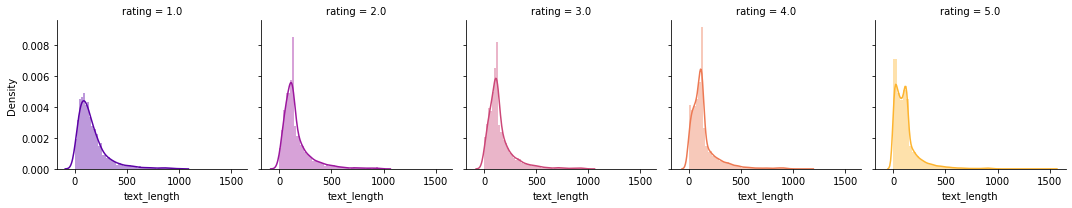

In [ ]:
a = sns.FacetGrid(data = df, col = 'rating', hue = 'rating', palette='plasma') # size=5
a.map(sns.distplot, "text_length")
df.groupby('rating').mean()['text_length']

Looks like there is a relationship with the amount of text in a review vs. the rating of the particular car.

## Cleaning the reviews

Creating helper functions to clean the data

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def lem(x):
    '''Lemmatizing the words'''
    lem = WordNetLemmatizer()
    lemma = [lem.lemmatize(t) for t in x]
    return lemma

def clean_text(x):
    '''Removing any punctuations'''
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_text2(x):
    '''Removing any words that are less than 3 letters'''
    pattern = r'\b\w{1,3}\b'
    text = re.sub(pattern,'',x)
    return x

def clean_numbers(x):
    '''More cleaning done'''
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '', x)
        x = re.sub('[0-9]{4}', '', x)
        x = re.sub('[0-9]{3}', '', x)
        x = re.sub('[0-9]{2}', '', x)
    return x

def lc_remove(text):
    '''Removing documents that are less than 3 words '''
    return ' '.join(word for word in text.split() if len(word)>3)

def removepunc(x):
    '''Removing punctuations'''
    return re.sub('[%s]' % re.escape(string.punctuation), ' ', x)

stop = stopwords.words('english');
stop.append('good')
stop.append('vehicle')
stop.append('great')
stop.append('ride')

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
df.review = df.review.apply(lambda x:removepunc(str(x)))
df.review = df.review.str.lower().str.split()
df.review = df.review.apply(lambda x:[item for item in x if item not in stop])
df.review = df.review.apply(lambda x:[item for item in x if not item.isdigit()]);
df.review = df.review.apply(lambda x:lem(x))

In [ ]:
df['review']=[" ".join(review) for review in df['review'].values]
df.review = df.review.apply(lambda x:clean_text(x))
df.review = df.review.apply(lambda x:clean_text2(x))
df['review'] = df['review'].apply(lambda x:clean_numbers(x))
df.review = df.review.apply(lambda x:gensim.utils.simple_preprocess(x))

In [ ]:
df['text_length'] = df['review'].apply(lambda x:len(x))
df = df[df.text_length > 6]
df.reset_index(inplace=True,drop=True)

In [ ]:
#Joining all the words in the review back to a string text.
df['review']=[" ".join(review) for review in df['review'].values]

<ipython-input-19-53cab6064923>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review']=[" ".join(review) for review in df['review'].values]


In [ ]:
a = sns.FacetGrid(data = df, col = 'rating', hue = 'rating', palette='plasma') # size=5
a.map(sns.distplot, "text_length")
df.groupby('rating').mean()['text_length']

/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.9/dist-packages

rating
1.0    82.048410
2.0    79.954041
3.0    78.304915
4.0    72.649907
5.0    64.751406
Name: text_length, dtype: float64

New text lengths after applying some data pre-processing on the corupus

In [ ]:
# with open('car_df_cleaned', 'wb') as f: #change
#     pickle.dump(car_df, f)         #change 
df.to_parquet(HOME_DIR/"all_files_cleaned.parquet")